C:\Users\monic\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


We have 3999 observations with 140 dimensions


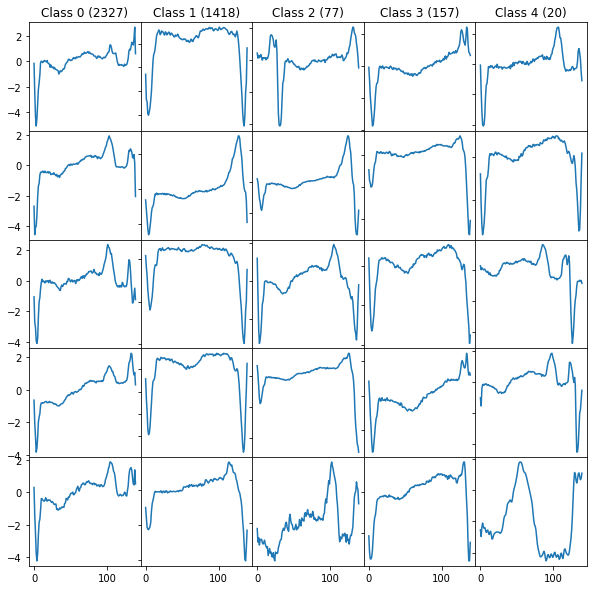

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 22 10:43:29 2016

@author: Rob Romijnders
"""
%matplotlib inline
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.contrib.tensorboard.plugins import projector
from AE_ts_model import Model, open_data, plot_data, plot_z_run

"""Hyperparameters"""
LOG_DIR = "."
config = {}  # Put all configuration information into the dict
config['num_layers'] = 2  # number of layers of stacked RNN's
config['hidden_size'] = 90  # memory cells in a layer
config['max_grad_norm'] = 5  # maximum gradient norm during training
config['batch_size'] = batch_size = 64
config['learning_rate'] = .005
config['crd'] = 1  # Hyperparameter for future generalization
config['num_l'] = 20  # number of units in the latent space

plot_every = 100  # after _plot_every_ GD steps, there's console output
max_iterations = 2000  # maximum number of iterations
dropout = 0.8  # Dropout rate
"""Load the data"""
X_train, X_val, y_train, y_val = open_data('../../data/ECG/')

N = X_train.shape[0]
Nval = X_val.shape[0]
D = X_train.shape[1]
config['sl'] = sl = D  # sequence length
print('We have %s observations with %s dimensions' % (N, D))

# Organize the classes
num_classes = len(np.unique(y_train))
base = np.min(y_train)  # Check if data is 0-based
if base != 0:
    y_train -= base
    y_val -= base

# Plot data   # and save high quality plt.savefig('data_examples.eps', format='eps', dpi=1000)
plot_data(X_train, y_train)

In [2]:
# Proclaim the epochs
epochs = np.floor(batch_size * max_iterations / N)
print('Train with approximately %d epochs' % epochs)

"""Training time!"""
model = Model(config)
sess = tf.Session()
perf_collect = np.zeros((2, int(np.floor(max_iterations / plot_every))))

if True:
    sess.run(model.init_op)
    writer = tf.summary.FileWriter(LOG_DIR, sess.graph)  # writer for Tensorboard

    step = 0  # Step is a counter for filling the numpy array perf_collect
    for i in range(max_iterations):
        batch_ind = np.random.choice(N, batch_size, replace=False)
        result = sess.run([model.loss, model.loss_seq, model.loss_lat_batch, model.train_step],
                          feed_dict={model.x: X_train[batch_ind], model.keep_prob: dropout})

        if i % plot_every == 0:
            # Save train performances
            perf_collect[0, step] = loss_train = result[0]
            loss_train_seq, lost_train_lat = result[1], result[2]

            # Calculate and save validation performance
            batch_ind_val = np.random.choice(Nval, batch_size, replace=False)

            result = sess.run([model.loss, model.loss_seq, model.loss_lat_batch, model.merged],
                              feed_dict={model.x: X_val[batch_ind_val], model.keep_prob: 1.0})
            perf_collect[1, step] = loss_val = result[0]
            loss_val_seq, lost_val_lat = result[1], result[2]
            # and save to Tensorboard
            summary_str = result[3]
            writer.add_summary(summary_str, i)
            writer.flush()

            print("At %6s / %6s train (%5.3f, %5.3f, %5.3f), val (%5.3f, %5.3f,%5.3f) in order (total, seq, lat)" % (
            i, max_iterations, loss_train, loss_train_seq, lost_train_lat, loss_val, loss_val_seq, lost_val_lat))
            step += 1

Train with approximately 32 epochs
At      0 /   2000 train (4.006, 2.041, 1.965), val (2.992, 1.907,1.085) in order (total, seq, lat)
At    100 /   2000 train (0.791, 0.786, 0.005), val (0.773, 0.772,0.001) in order (total, seq, lat)
At    200 /   2000 train (0.788, 0.782, 0.006), val (0.735, 0.735,0.001) in order (total, seq, lat)
At    300 /   2000 train (0.561, 0.553, 0.009), val (0.555, 0.548,0.007) in order (total, seq, lat)
At    400 /   2000 train (0.506, 0.498, 0.008), val (0.452, 0.449,0.003) in order (total, seq, lat)
At    500 /   2000 train (0.505, 0.498, 0.007), val (0.310, 0.307,0.003) in order (total, seq, lat)
At    600 /   2000 train (0.389, 0.383, 0.006), val (0.559, 0.553,0.006) in order (total, seq, lat)
At    700 /   2000 train (0.248, 0.242, 0.007), val (0.068, 0.064,0.003) in order (total, seq, lat)
At    800 /   2000 train (0.180, 0.174, 0.005), val (0.051, 0.048,0.003) in order (total, seq, lat)
At    900 /   2000 train (0.416, 0.408, 0.008), val (0.186, 0.182

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 960 samples in 0.011s...
[t-SNE] Computed neighbors for 960 samples in 0.567s...
[t-SNE] Computed conditional probabilities for sample 960 / 960
[t-SNE] Mean sigma: 0.347878
[t-SNE] Computed conditional probabilities in 0.782s
[t-SNE] Iteration 50: error = 52.9569855, gradient norm = 0.1976358 (50 iterations in 16.152s)
[t-SNE] Iteration 100: error = 51.4427414, gradient norm = 0.1713726 (50 iterations in 3.394s)
[t-SNE] Iteration 150: error = 51.2964363, gradient norm = 0.1665287 (50 iterations in 2.550s)
[t-SNE] Iteration 200: error = 51.2668571, gradient norm = 0.1667873 (50 iterations in 2.440s)
[t-SNE] Iteration 250: error = 51.2868500, gradient norm = 0.1819480 (50 iterations in 2.312s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.286850
[t-SNE] Iteration 300: error = 0.3426441, gradient norm = 0.0003902 (50 iterations in 2.078s)
[t-SNE] Iteration 350: error = 0.3177535, gradient norm = 0.0001748

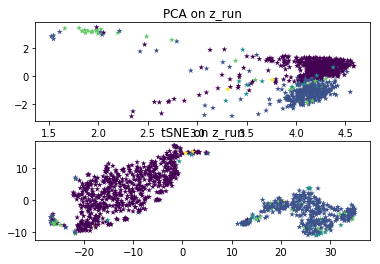

In [3]:
##Extract the latent space coordinates of the validation set
start = 0
label = []  # The label to save to visualize the latent space
z_run = []

while start + batch_size < Nval:
    run_ind = range(start, start + batch_size)
    z_mu_fetch = sess.run(model.z_mu, feed_dict={model.x: X_val[run_ind], model.keep_prob: 1.0})
    z_run.append(z_mu_fetch)
    start += batch_size

z_run = np.concatenate(z_run, axis=0)
label = y_val[:start]

plot_z_run(z_run, label)

In [4]:
# Save the projections also to Tensorboard
saver = tf.train.Saver()
saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"), step)
config = projector.ProjectorConfig()
# You can add multiple embeddings. Here we add only one.
embedding = config.embeddings.add()
embedding.tensor_name = model.z_mu.name
# Link this tensor to its metadata file (e.g. labels).
embedding.metadata_path = os.path.join(LOG_DIR, 'metadata.tsv')

# Saves a configuration file that TensorBoard will read during startup.
projector.visualize_embeddings(writer, config)
saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"), step + 1)
writer.flush()

# Now open Tensorboard with
#  $tensorboard --logdir = LOG_DIR

In [5]:
# apply knn in the z_run space, 
# check the accuracy 
names = []
for i in label: names.append(str(i)); 

explained variance ratio (first two components): [0.45855698 0.26305905 0.12531203 0.0891954  0.02448085]


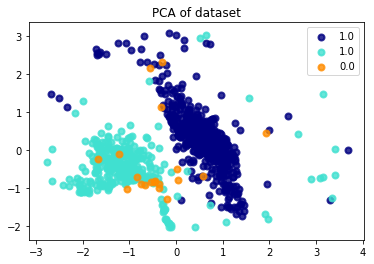

In [6]:
import matplotlib.pylab as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
X_r = pca.fit(z_run).transform(z_run)
y = y_val[:start]
target_names = names
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange', 'red', 'yellow']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of dataset')


plt.show()


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

def fit_pca(z_run, n_clusters):
    np.random.seed(5)
    pca = PCA(n_components=n_clusters)
    X = pca.fit(z_run).transform(z_run)
    est = KMeans(n_clusters=n_clusters)
    est.fit(X)
    cluster_labels = est.labels_
    return est,cluster_labels,X


def plot_pca_clusters(X, y, cluster_labels, plot_cluster_id=False):
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(121, projection='3d', elev=48, azim=134)
    ax.scatter(X[:, 3], X[:, 0], X[:, 2],
               c=cluster_labels.astype(np.float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('1')
    ax.set_ylabel('2')
    ax.set_zlabel('3')
    ax.set_title('Cluster')
    ax.dist = 12
    if plot_cluster_id==True:

        llist = []
        for k in range(n_clusters):
            llist.append((str(k),k))

        for name, l in llist:
            if len(X[cluster_labels == l])>0:
                ax.text3D(X[cluster_labels == l, 3].mean(),
                      X[cluster_labels == l, 0].mean(),
                      X[cluster_labels == l, 2].mean() + 2, name,
                      horizontalalignment='center',
                      bbox=dict(alpha=.2, edgecolor='w', facecolor='w'))
    # Plot the ground truth
    ax = fig.add_subplot(122, projection='3d', elev=48, azim=134)

    if plot_cluster_id==True:
        unique_l=np.unique(label)
        llist = []
        for k in range(len(unique_l)):
            llist.append((str(k),k))
        for name, l in llist:
            ax.text3D(X[y == l, 3].mean(),
                      X[y == l, 0].mean(),
                      X[y == l, 2].mean() + 2, name,
                      horizontalalignment='center',
                      bbox=dict(alpha=.2, edgecolor='w', facecolor='w'))
    # Reorder the labels to have colors matching the cluster results
    #y = np.choose(y, [1, 2, 0]).astype(np.float)
    ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y, edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('1')
    ax.set_ylabel('2')
    ax.set_zlabel('3')
    ax.set_title('Ground Truth')
    ax.dist = 12

    fig.show()
    
def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd

def get_accuracy(y,cluster_labels):
    '''
    Function to check if a clustering assigns clusters proportionally to the classes
    Prints confusion matrix, accuracy.
    
    Inputs:
        y: true class label
        cluster_labels: predicted cluster
    
    '''
    
    num_classes = len(np.unique(y)) 
    n_clusters = len(np.unique(cluster_labels)) 
    print(pd.DataFrame(y).reset_index().groupby(0).agg('count'))
    print(pd.DataFrame(cluster_labels).reset_index().groupby(0).agg('count'))
    # Assign a label to each centroid
    # Count total number of labels per centroid, using the label of each training
    # sample to their closest centroid
    counts = np.zeros(shape=(n_clusters, num_classes))
    one_hot_label = one_hot(y)
    for i in range(len(cluster_labels)):
        counts[int(cluster_labels[i])] += one_hot_label[i]
    print(counts)

    # Assign the most frequent label to the centroid
    labels_map = [np.argmax(c) for c in counts]
    # Evaluation ops
    # Lookup: centroid_id -> label
    cluster_label_mapped = []
    for i in range(len(cluster_labels)):
        cluster_label_mapped.append(labels_map[cluster_labels[i]])
    # Compute accuracy
    correct_prediction = cluster_label_mapped==y
    accuracy = np.mean(correct_prediction)

    # Test Model
    print("Test Accuracy:", accuracy)

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y,cluster_label_mapped)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=np.unique([str(i) for i in np.unique(y)]),
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    #plt.figure()
    #plot_confusion_matrix(cnf_matrix, classes=np.unique([str(i) for i in cluster_label]), normalize=True,
    #                      title='Normalized confusion matrix')

    plt.show()

C:\Users\monic\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


   index
0       
0    570
1    331
2     19
3     36
4      4
   index
0       
0    193
1    112
2     30
3     35
4    261
5    134
6     75
7     20
8     38
9     62
[[191.   1.   1.   0.   0.]
 [  0. 101.   6.   5.   0.]
 [  5.  10.   0.  15.   0.]
 [ 30.   3.   0.   1.   1.]
 [259.   1.   1.   0.   0.]
 [  0. 125.   2.   6.   1.]
 [ 70.   2.   1.   1.   1.]
 [ 14.   3.   2.   0.   1.]
 [  1.  29.   5.   3.   0.]
 [  0.  56.   1.   5.   0.]]
Test Accuracy: 0.9270833333333334
Confusion matrix, without normalization
[[564   1   0   5   0]
 [ 10 311   0  10   0]
 [  5  14   0   0   0]
 [  2  19   0  15   0]
 [  3   1   0   0   0]]


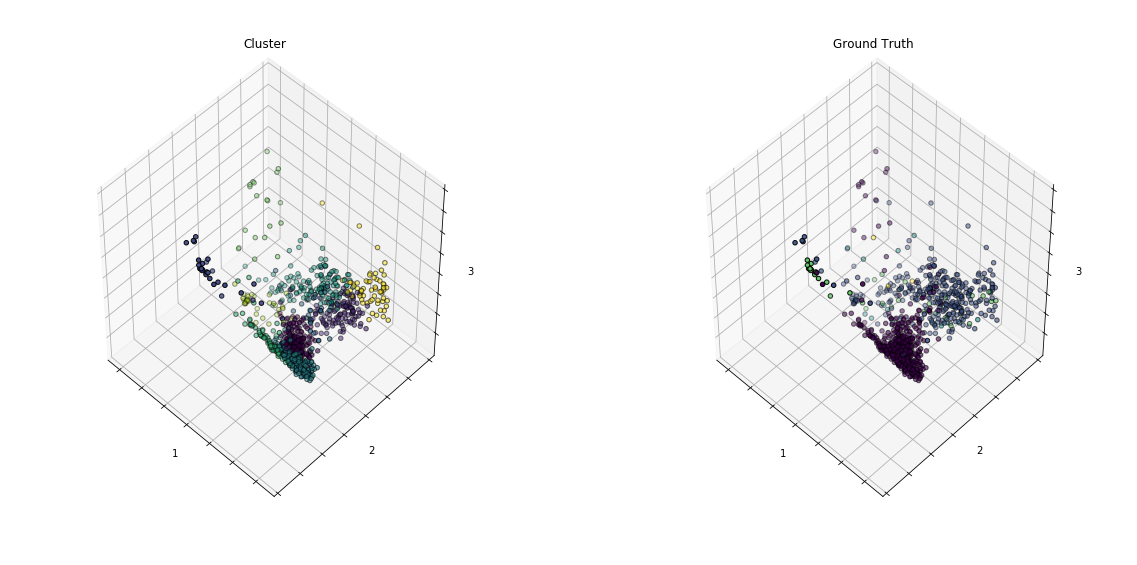

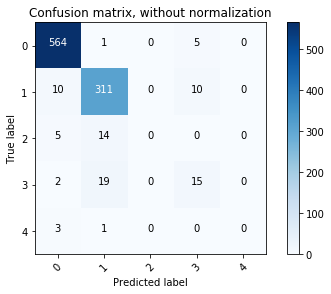

In [21]:

n_clusters = 10
assert n_clusters<=np.shape(z_run)[1]

y = np.array(y_val[:start])
y = y.astype(int)
est,cluster_labels,X = fit_pca(z_run, n_clusters)
plot_pca_clusters(X, y, cluster_labels)
cluster_label_mapped = get_accuracy(y,cluster_labels)

# safety check: get_accuracy(y,y)
